In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
# Load the file
with open("/home/trapfishscott/Cambridge24.25/Energy_thesis/Agents/by_trip_df.pkl", "rb") as f:
    loaded_data = pickle.load(f)

In [5]:
## times
with open("/home/trapfishscott/Cambridge24.25/Energy_thesis/Agents/sim_times200.pkl", "rb") as f:
    times = pickle.load(f)

    

In [6]:
np.mean(times)

np.float64(28.06499367117882)

In [7]:
trips_only = loaded_data.dropna()

In [8]:
trips_only

,individual_ids,all_dates,we_wd,all_distance,all_start_t,all_end__t,all_seqs
1,0,02-01-2017,1,5.93,1034.74,1092.58,"(3, 2)"
6,0,07-01-2017,2,6.29,1034.76,1050.28,"(2, 2)"
7,0,07-01-2017,2,5.45,1115.58,1120.13,"(2, 3)"
8,0,07-01-2017,2,3.33,1213.62,1272.79,"(3, 2)"
9,0,07-01-2017,2,6.79,1359.94,1438.14,"(2, 3)"
...,...,...,...,...,...,...,...
5098,29,25-03-2017,2,9.59,1403.20,1433.47,"(2, 3)"
5099,29,26-03-2017,2,1.59,502.69,507.35,"(3, 2)"
5100,29,26-03-2017,2,4.65,988.07,1091.71,"(2, 3)"
5101,29,26-03-2017,2,2.10,1101.91,1139.00,"(3, 2)"


In [9]:
## Looking at original data


# Load the file
with open("/home/trapfishscott/Cambridge24.25/Energy_thesis/Data/df_car.pkl", "rb") as f:
    car_nts_data = pickle.load(f)

In [10]:


def compare_dists(True_df, Sim_df, trip_type_index, variable_index):
    ## Comparing individual trip stats

    trip_type = True_df.TripType.unique()

    stats_T = True_df[True_df.TripType == trip_type[trip_type_index]][["TripStart",	"TripEnd", "TripDisExSW" ]]

    stats_S = Sim_df[Sim_df.all_seqs == trip_type[trip_type_index]][["all_start_t", "all_end__t", "all_distance"]]

    hist_titles = ["Trip Start Time", "Trip End Time", "Distance"]

    mapping = {(2,3): "other->home",
            (3,2): "home->other",
            (3,1): "home->work",
            (2,2): "other->other",
            (1,3): "work->home",
            (1,2): "work->other",
            (2,1): "other->work"}

    # Plot histogram
    #plt.figure(figsize=(7, 5))
    plt.hist(stats_T.iloc[:,variable_index], bins=75, alpha=0.5, label="Real", color="blue", density=True)
    plt.hist(stats_S.iloc[:,variable_index], bins=75, alpha=0.5, label="Simulated", color="red", density=True)

    if variable_index == 2:
        plt.xlim(0,100)

    # Labels and legend
    plt.xlabel(f"{hist_titles[variable_index]}")
    plt.ylabel("Density")
    plt.title(f"Histogram of {hist_titles[variable_index]} for trip type: {mapping[trip_type[trip_type_index]]}.")
    plt.legend()
    plt.grid()

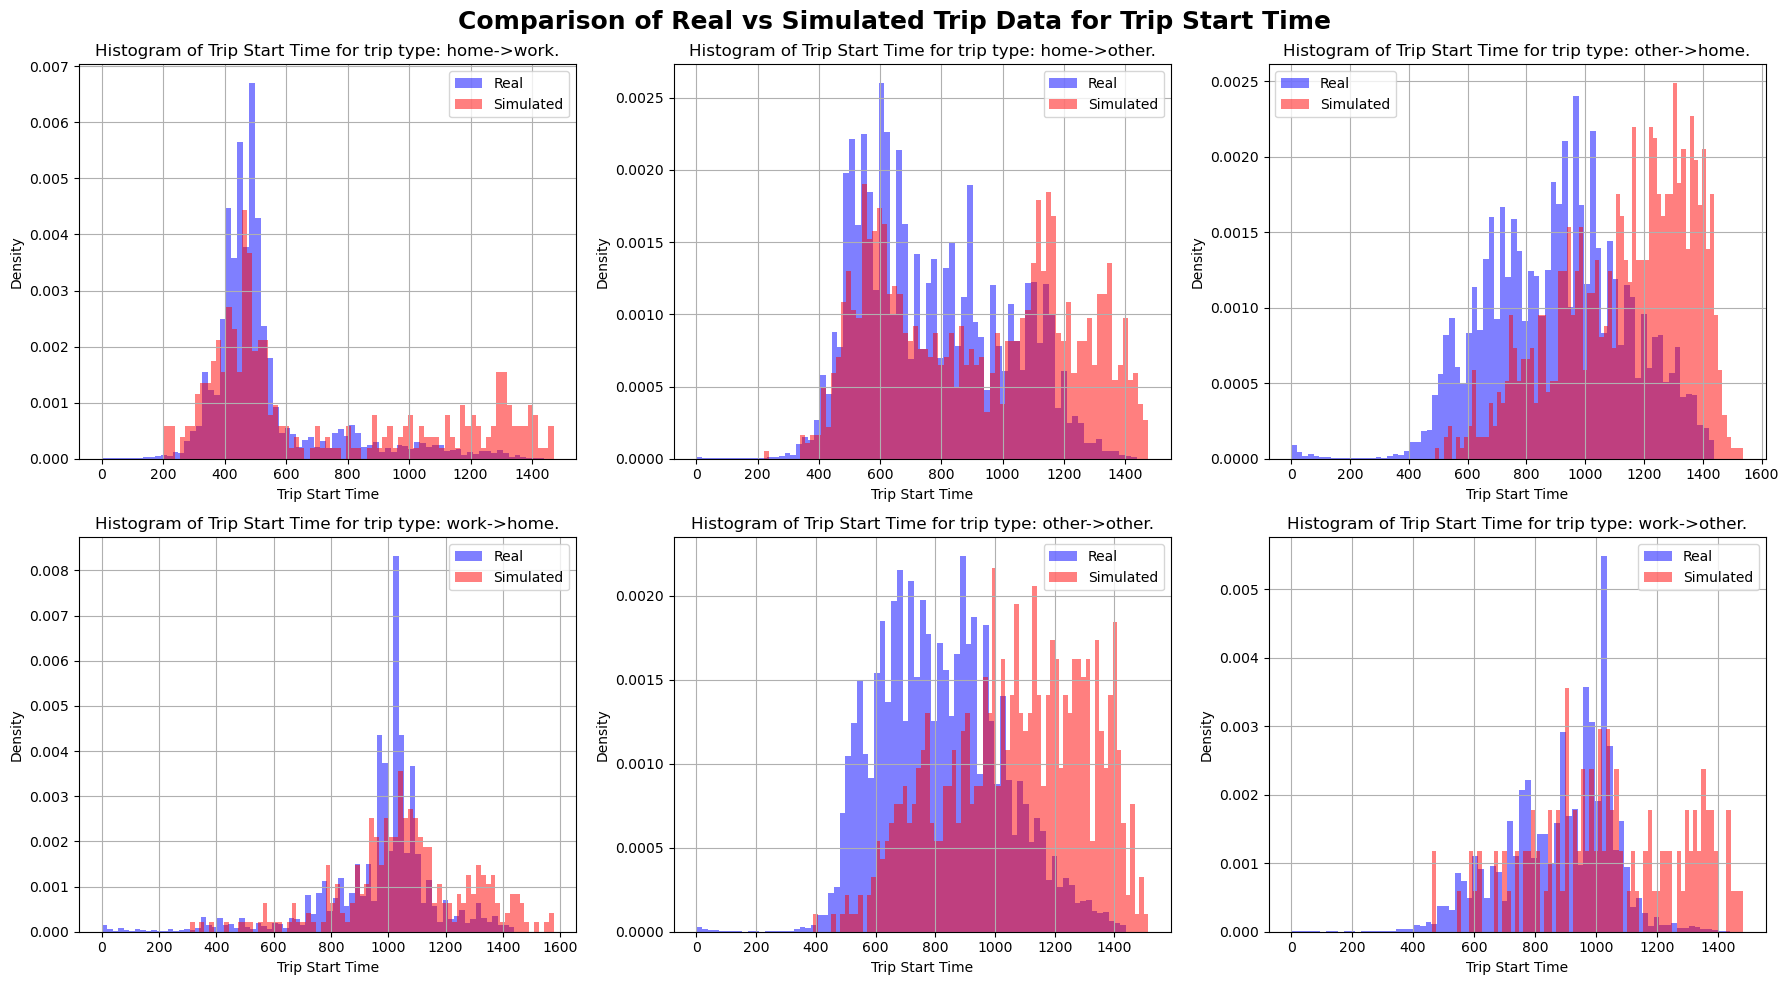

In [11]:
plt.figure(figsize=(18, 10))
# 🔹 Add an overall title
plt.suptitle("Comparison of Real vs Simulated Trip Data for Trip Start Time", fontsize=18, fontweight="bold")

for i in range(6):
    plt.subplot(2,3,i+1)
    compare_dists(True_df=car_nts_data, Sim_df=trips_only, trip_type_index=i, variable_index=0)


plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

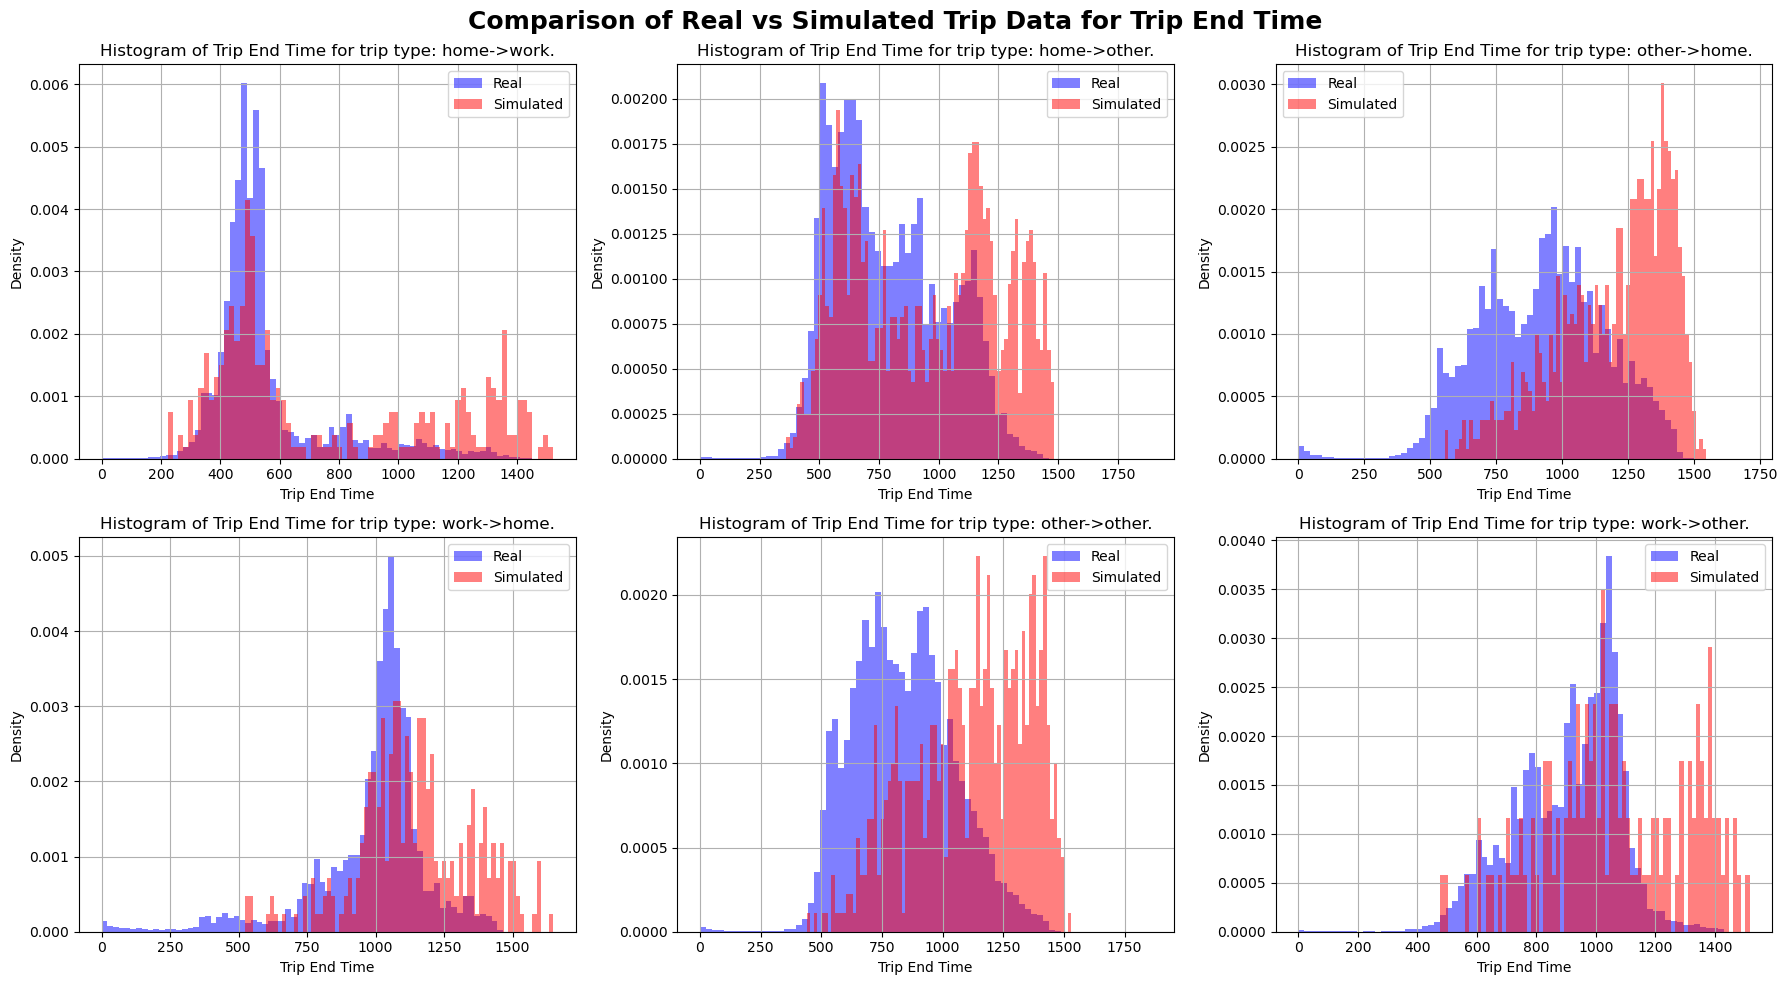

In [12]:
plt.figure(figsize=(18, 10))
# 🔹 Add an overall title
plt.suptitle("Comparison of Real vs Simulated Trip Data for Trip End Time", fontsize=18, fontweight="bold")

for i in range(6):
    plt.subplot(2,3,i+1)
    compare_dists(True_df=car_nts_data, Sim_df=trips_only, trip_type_index=i, variable_index=1)


plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

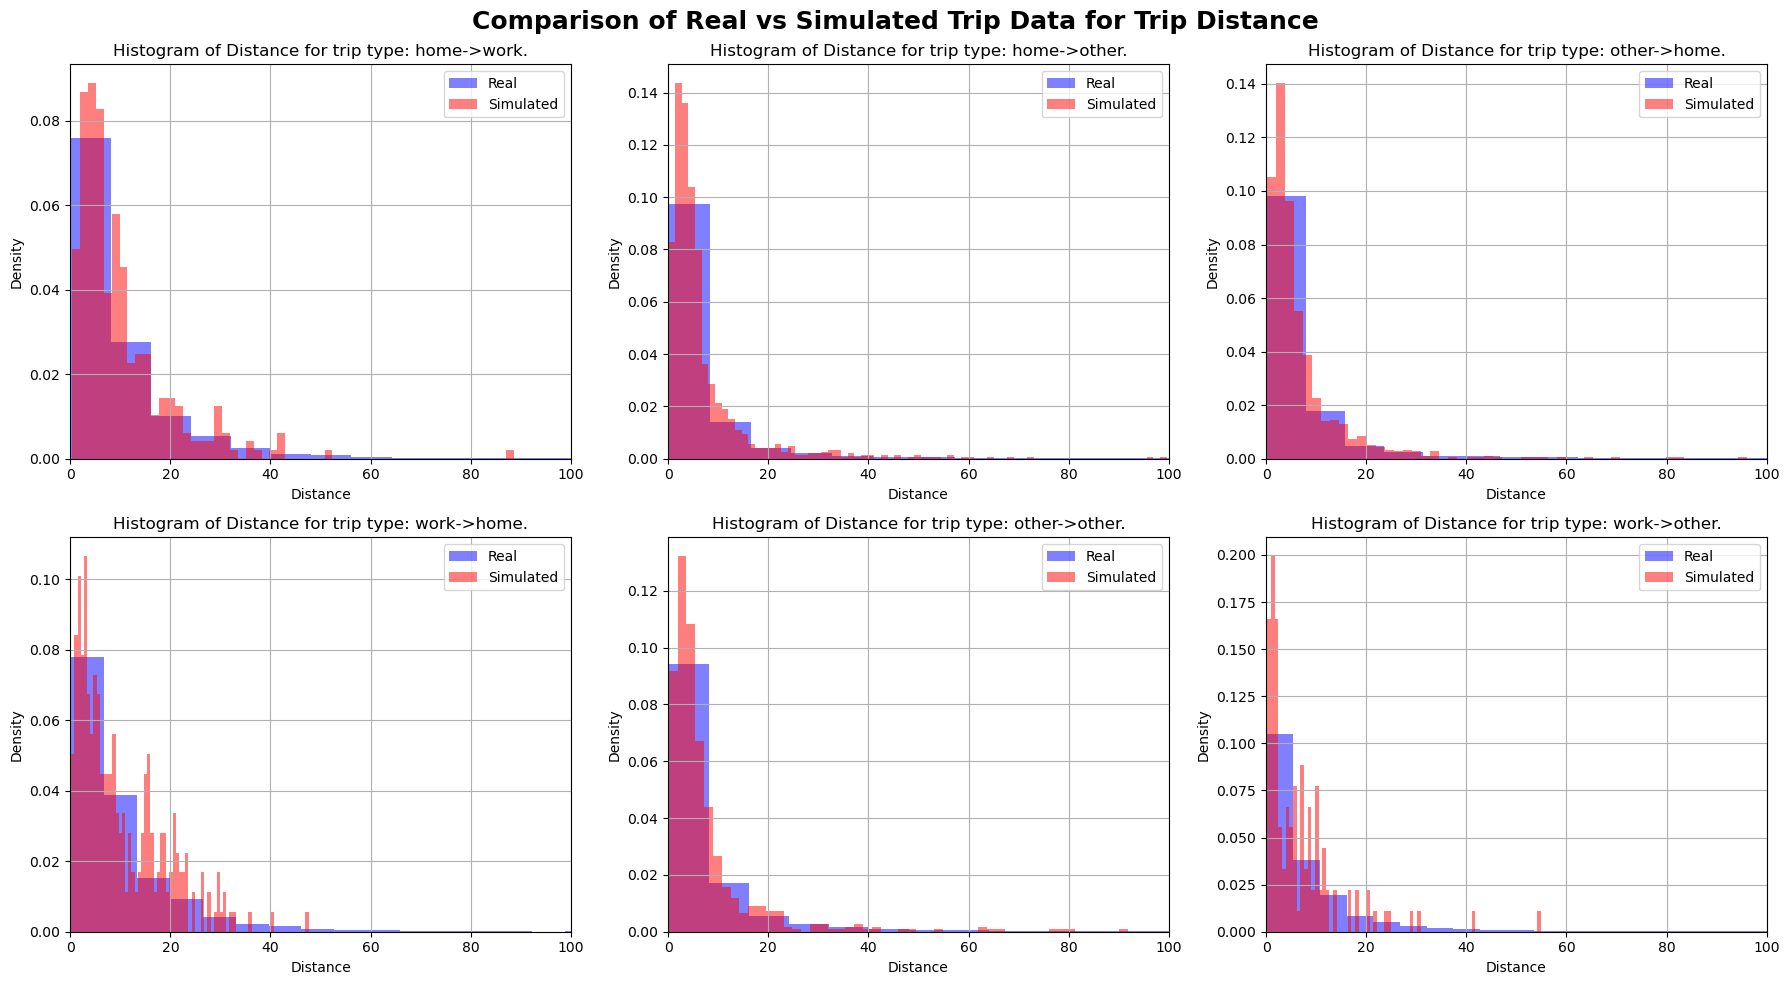

In [13]:
plt.figure(figsize=(18, 10))
# 🔹 Add an overall title
plt.suptitle("Comparison of Real vs Simulated Trip Data for Trip Distance", fontsize=18, fontweight="bold")

for i in range(6):
    plt.subplot(2,3,i+1)
    compare_dists(True_df=car_nts_data, Sim_df=trips_only, trip_type_index=i, variable_index=2)


plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [14]:
def gen_EV_Charge_nodes(sim_df):

    working_data = sim_df.copy()

    # Extracting final trip location

    working_data["trip_stop_loc"] = working_data["all_seqs"].apply(lambda x: int(x[-1]) if x != None else None)

    # Gettting an ordered time series for easier calculation of stop times

    minutes = [1440 for i in range(len(working_data["all_dates"].unique()))]

    min_cum_sum = np.cumsum(minutes)

    mapping = dict(zip(working_data["all_dates"].unique(), min_cum_sum))

    working_data["dates_min_cum"] = working_data["all_dates"].map(mapping)

    # unique individuals
    unique_i = working_data["individual_ids"].unique()

    for i in unique_i:

        # Aux DF to help with final calculations
        aux_df = working_data[(working_data["individual_ids"] == i) & (working_data["all_seqs"].notna())].copy()

        aux_df["all_start+1"] = aux_df["all_start_t"].shift(-1)
        aux_df["all_dates+1"] = aux_df["all_dates"].shift(-1)
        aux_df["dates_min_cum+1"] = aux_df["dates_min_cum"].shift(-1)
        aux_df["distance_trip+1"] = aux_df["all_distance"].shift(-1)
        #aux_df["trip_stop_loc+1"] = aux_df["trip_stop_loc"].shift(-1)
        #aux_df["trip_stop_loc+2"] = aux_df["trip_stop_loc"].shift(-2)
        #aux_df["trip_stop_loc+3"] = aux_df["trip_stop_loc"].shift(-3)

        aux_df = aux_df[["all_dates", "dates_min_cum", "all_end__t", "all_dates+1", "dates_min_cum+1", "all_start+1", "distance_trip+1"]]

        aux_df["time_stop_final_loc"] = (aux_df["dates_min_cum+1"] + aux_df["all_start+1"]) - (aux_df["dates_min_cum"] + aux_df["all_end__t"])

        # Update `working_data` efficiently using `.loc[]`
        working_data.loc[aux_df.index, ["time_stop_final_loc", "distance_trip+1"]] = aux_df[["time_stop_final_loc", "distance_trip+1"]]

    working_data.drop("dates_min_cum", axis=1, inplace=True)

    return working_data


In [15]:
working_data = gen_EV_Charge_nodes(loaded_data)

In [17]:
def generate_charger(x, home_charger_likelihood=0.96, work_charger_likelihood=0.62, public_charger_likelihood=0.17):
    if x == 3:
        return random.choices([1,0], weights=[home_charger_likelihood,1-home_charger_likelihood])[0]
    if x == 2:
        return random.choices([1,0], weights=[public_charger_likelihood,1-public_charger_likelihood])[0]
    else:
        return random.choices([1,0], weights=[work_charger_likelihood,1-work_charger_likelihood])[0]

In [18]:
working_data["is_charger"] = working_data["time_stop_final_loc"].apply(lambda x: generate_charger(x))

In [19]:
def parking_stackplot(df, timeframe=30):
    parked_df = df.groupby(["all_dates", "trip_stop_loc"])["trip_stop_loc"].count().unstack(fill_value=0)

    parked_df.index = pd.to_datetime(parked_df.index, format="%d-%m-%Y")
    parked_df = parked_df.sort_index()

    parked_df=parked_df.iloc[:timeframe,:]

    plt.stackplot(parked_df.index, parked_df.T, labels=parked_df.columns)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

    plt.show()

    return parked_df
        

In [37]:
working_data

,individual_ids,all_dates,we_wd,all_distance,all_start_t,all_end__t,all_seqs,trip_stop_loc,time_stop_final_loc,distance_trip+1,is_charger
0,0,01-01-2017,2,NaN,NaN,NaN,None,NaN,NaN,NaN,1
1,0,02-01-2017,1,5.93,1034.74,1092.58,"(3, 2)",2.0,7142.18,6.29,0
2,0,03-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0
3,0,04-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1
4,0,05-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
5102,29,26-03-2017,2,3.91,1215.45,1341.34,"(2, 3)",3.0,NaN,NaN,1
5103,29,27-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1
5104,29,28-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0
5105,29,29-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0


In [36]:
parking_times = working_data.groupby("trip_stop_loc")["time_stop_final_loc"].median()

print("Median stop time at different locations")
print(f"1 --> Work --> {parking_times[1]/60:.2f} hrs")
print(f"2 --> Other --> {parking_times[2]/60:.2f} hrs")
print(f"3 --> Home --> {parking_times[3]/60:.2f} hrs")



Median stop time at different locations
1 --> Work --> 6.03 hrs
2 --> Other --> 2.22 hrs
3 --> Home --> 11.13 hrs


In [ ]:
def charging_choice(row, min_time_to_charge=60):
    if row["time_stop_final_loc"] < 60:
        return 0
    

In [20]:
## Vehicle DF

vehicle_df = pd.read_csv("/home/trapfishscott/Cambridge24.25/Energy_thesis/Data/NTS_data/UKDA-5340-tab/tab/vehicle_eul_2002-2023.tab", delimiter="\t")

In [21]:
vehicle_props = vehicle_df[vehicle_df["VehMakeModel_B02ID"].isin([1, 2, 3 ,4])]["VehMakeModel_B02ID"].value_counts(normalize=True)*100

mapping = {1: "Small car",
           2: "Small/medium car",
           3: "Medium car",
           4: "Large car"}

vehicle_props.index = vehicle_props.index.map(mapping)

vehicle_props

VehMakeModel_B02ID
Small/medium car    32.269950
Medium car          31.452932
Small car           20.937455
Large car           15.339663
Name: proportion, dtype: float64

In [ ]:
charging_rates = {1: 2.7,            # Work
                  2: 11,            # Other
                  3: 2.3}            # Home

# car_stats = {"Small car": }

# Parameters needed
# Battery size (distributions among the population)   # Average: 70.7kWh
# Energy Efficiency  #Average: 302 Wh/mi, Energy required to drive the vehicle for one mile

# Use average then try some distributions and compare sensitivities

# https://ev-database.org/uk/cheatsheet/useable-battery-capacity-electric-car

SyntaxError: expression expected after dictionary key and ':' (359268463.py, line 5)

In [133]:
# Functions to calculate energy consumption

def energy_per_trip(row, distance_col_name, energy_efficiency=302):
    if pd.notna(row[distance_col_name]):
        energy_per_trip = (energy_efficiency * row[distance_col_name])/1000   #in KwH
        return energy_per_trip
    else:
        return None

def assign_ev(individual_ids, battery_capacities_list, weights):
    """
    Assigns an EV, given by battery capacity to each individual

    Args:
        individual_ids (list/array): A list of all unique individual ids, usually under df["individual_ids"]
        battery_capacities_list (list): Collection of battery capacities to sample from
        weights (list): sample weights

    Returns:
        dict: Mapping of individual ids to battery capacity
    """    
    num_to_generate = len(individual_ids)
    allocation = random.choices(battery_capacities_list, weights=weights, k=num_to_generate)

    mapping = dict(zip(individual_ids, allocation))

    return mapping

def allocate_SOC(df):
    total_SOC_history = []

    for i in df.individual_ids.unique():
        
        df_for_i = df[df.individual_ids == i]
        #print(df_for_i)

        start_SOC = None

        for index, row in df_for_i.iterrows():

            #print(row["energy_for_trip+1"], row["EV_full_capacity_i"])
            if pd.isna(row["energy_for_trip+1"]) and start_SOC is None:
                total_SOC_history.append(start_SOC)

            elif pd.notna(row["energy_for_trip+1"]) and start_SOC is None:
                start_SOC = np.random.uniform(row["energy_for_trip+1"], row["EV_full_capacity_i"])
                total_SOC_history.append(start_SOC)

            elif pd.isna(row["energy_for_trip+1"]) and start_SOC is not None:
                total_SOC_history.append(start_SOC)

            elif pd.notna(row["energy_for_trip+1"]) and start_SOC is not None:
                start_SOC -= row["energy_for_trip"]
                total_SOC_history.append(start_SOC)
    
    return total_SOC_history



# SOC allocating algorithm

# For every i

# First trip assign next trip distance -- full charge uniformly

# If Nan leave SOC as is

# If not remove energy_for_trip


In [135]:
# Applying maths

working_data["energy_for_trip"] = working_data.apply( (lambda row: energy_per_trip(row, distance_col_name="all_distance")), axis=1)
working_data["energy_for_trip+1"] = working_data.apply( (lambda row: energy_per_trip(row, distance_col_name="distance_trip+1")), axis=1)

ev_mapping = assign_ev(working_data["individual_ids"].unique(), battery_capacities_list=[70.7], weights=[1])

working_data["EV_full_capacity_i"] = working_data["individual_ids"].map(ev_mapping)

working_data["SOC_history_i"] = allocate_SOC(working_data)

In [137]:
working_data.to_csv("/home/trapfishscott/Cambridge24.25/Energy_thesis/Data/sim_trips.csv", index=False)

In [136]:
working_data

,individual_ids,all_dates,we_wd,all_distance,all_start_t,all_end__t,all_seqs,trip_stop_loc,time_stop_final_loc,distance_trip+1,is_charger,energy_for_trip,EV_full_capacity_i,energy_for_trip+1,SOC_history_i
0,0,01-01-2017,2,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN,70.7,NaN,NaN
1,0,02-01-2017,1,5.93,1034.74,1092.58,"(3, 2)",2.0,7142.18,6.29,0,1.79086,70.7,1.89958,34.333645
2,0,03-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN,70.7,NaN,34.333645
3,0,04-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN,70.7,NaN,34.333645
4,0,05-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN,70.7,NaN,34.333645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5102,29,26-03-2017,2,3.91,1215.45,1341.34,"(2, 3)",3.0,NaN,NaN,1,1.18082,70.7,NaN,-269.928533
5103,29,27-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN,70.7,NaN,-269.928533
5104,29,28-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN,70.7,NaN,-269.928533
5105,29,29-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN,70.7,NaN,-269.928533


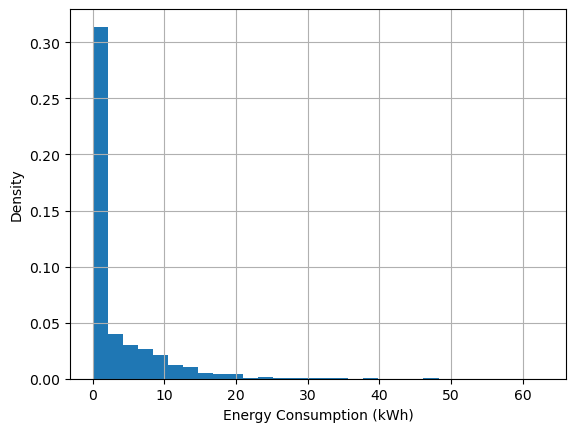

In [75]:
daily_energy_consumptions = working_data.groupby(["individual_ids", "all_dates"])["energy_for_trip"].sum()

plt.hist(daily_energy_consumptions.values, bins=30, density=True)
plt.xlabel("Energy Consumption (kWh)")
plt.ylabel("Density")
plt.grid()
plt.show()

In [76]:
working_data

,individual_ids,all_dates,we_wd,all_distance,all_start_t,all_end__t,all_seqs,trip_stop_loc,time_stop_final_loc,distance_trip+1,is_charger,energy_for_trip
0,0,01-01-2017,2,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN
1,0,02-01-2017,1,5.93,1034.74,1092.58,"(3, 2)",2.0,7142.18,6.29,0,1.79086
2,0,03-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN
3,0,04-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN
4,0,05-01-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5102,29,26-03-2017,2,3.91,1215.45,1341.34,"(2, 3)",3.0,NaN,NaN,1,1.18082
5103,29,27-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,1,NaN
5104,29,28-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN
5105,29,29-03-2017,1,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN
